In [220]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [222]:
def plot_values(x, y, color="red", ls="solid", marker="+", title="Function plotted", label="f(x)",
                second_plot_y=None, second_color="green", second_label="Learned derivative", second_ls=":"):
    x = x.numpy()
    y = y.numpy()
    fig, ax = plt.subplots()
    
    ax.grid(ls=":", color="grey")
    
    ax.plot(x, y, color=color, marker=marker, ls=ls, label=label)
    if second_plot_y is not None:
        ax.plot(x, second_plot_y, color=second_color, marker=marker, ls=second_ls, label=second_label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    
    ax.legend()
    
    plt.show()
    plt.close()

### Function space elements and basis

We define a function from a subspace with dimension 2, spanned by the basis functions $\sin, \cos$.

In [225]:
basis_functions = [lambda x: torch.sin(x),
                   lambda x: torch.cos(x)]

basis_functions_numpy = [lambda x: np.sin(x),
                         lambda x: np.cos(x)]

def parametrized_function(x, p_sin, p_cos):
    global basis_functions
    value = p_sin*basis_functions[0](x) + p_cos*basis_functions[1](x)
    return value

def parametrized_function_numpy(x, p_sin, p_cos):
    global basis_functions_numpy
    value = p_sin*basis_functions_numpy[0](x) + p_cos*basis_functions_numpy[1](x)
    return value

### Parameter representation

The parameter vector represents the function in the latent space $\mathbb{R}^3$.

In [228]:
p_sin = 1
p_cos = 0

In [230]:
coefficients = [p_sin, p_cos]

X_values = torch.linspace(0, 10, 100)
Y_values = parametrized_function(X_values, p_sin, p_cos)

### Visualizing one example function

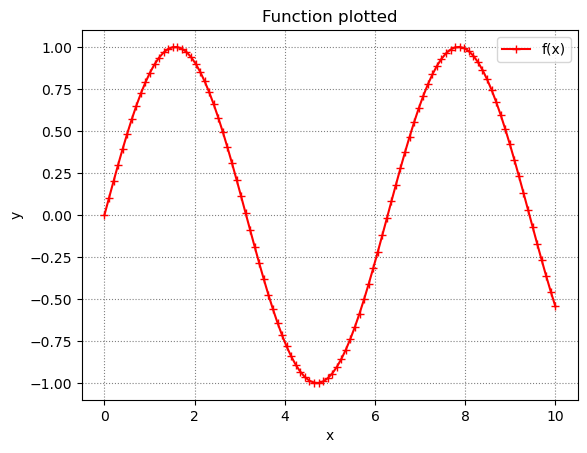

In [233]:
plot_values(X_values, Y_values)

### Retrieve the parameters

We want to find the basis representation of a function. This serves as the encoder part of the network mapping from the "function space" to the latent space. There are plenty of ways to do it, for example a least-square fitting using the curve_fit method by scipy.

In [236]:
para, _ = curve_fit(parametrized_function_numpy, X_values.numpy(), Y_values.numpy())

print(para)

[1.00000000e+00 4.94068727e-10]


### Model parts

The total Operator model comprises of an Encoder, a Neural Network in the latent space and a Decoder. In this example we want to model the derivative operator $\mathcal{O} = \nabla$, which is a linear Operator. We therefore use a Linear Layer without bias and activation as the latent neural network.

In [239]:
class Encoder(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.function = func
        
    def forward(self, X_values, Y_values):
        para, _ = curve_fit(self.function, X_values, Y_values)
        return para

                            
class LatentLinearLayer(nn.Module):
    def __init__(self, basis_dimension):
        super().__init__()
        self.layer = nn.Linear(basis_dimension, basis_dimension, bias=False)
        
    def forward(self, P_values):
        return self.layer(P_values)
                            
                            
class Decoder(nn.Module):
    def __init__(self, basis_functions):
        super().__init__()
        self.basis = basis_functions
        
    def forward(self, X_values, parameters):
        Y_values = torch.zeros(parameters.shape[0], X_values.shape[0])
        for i in range(parameters.shape[0]):
            for j in range(len(basis_functions)):
                Y_values[i, :] += parameters[i,j] * basis_functions[j](X_values)
        return Y_values

In [241]:
class SimpleOperatorNetwork(nn.Module):
    def __init__(self, basis, parametrized_function):
        super().__init__()
        self.basis = basis
        self.basis_dimension = len(basis)
        self.parametrized_function = parametrized_function
        
        self.Encoder = Encoder(self.parametrized_function)
        self.LatentLinearLayer = LatentLinearLayer(self.basis_dimension)
        with torch.no_grad():
            self.LatentLinearLayer.layer.weight.copy_(torch.eye(self.basis_dimension))
        self.Decoder = Decoder(self.basis)
        
    def forward(self, X_values, Y_values):
        parameters = self.Encoder(X_values, Y_values)
        transformed_parameters = self.LatentLinearLayer(torch.tensor(parameters, dtype=torch.float32).unsqueeze(0))
        transformed_Y_values = self.Decoder(X_values, transformed_parameters)
        return transformed_Y_values

### Creating the training set

We create a training set of y-values for a function and it's derivative. We do so by randomly sampling parameters and transforming them to the "function space" (evaluating the parametrized function).
We know how the differentiation operator looks like in the parameter-space-matrix representation, so we can just create the derivatives by performing a vector-matrix multiplication.

In [244]:
N = 2000
X_values = torch.linspace(0, 10, 100) 

derivative_operator = torch.tensor([[0, 1],
                                    [-1, 0]], dtype=torch.float32)

parameters = torch.tensor([2, 2])*torch.rand(size=(N, 2))

der_parameters = torch.matmul(parameters, derivative_operator)

Dec = Decoder(basis_functions)
Y_values = Dec(X_values, parameters)
Y_der_values = Dec(X_values, der_parameters)

### Visualizing two instances of the training set

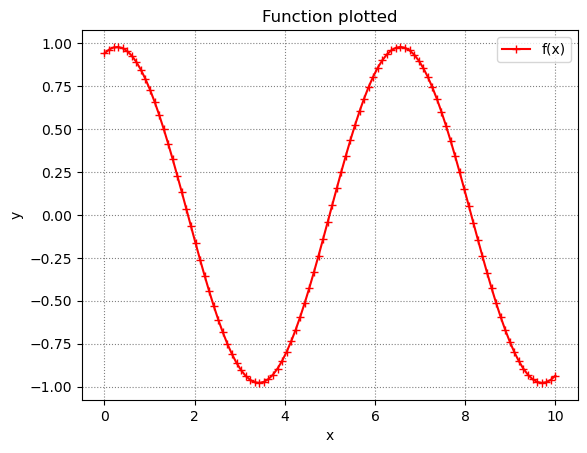

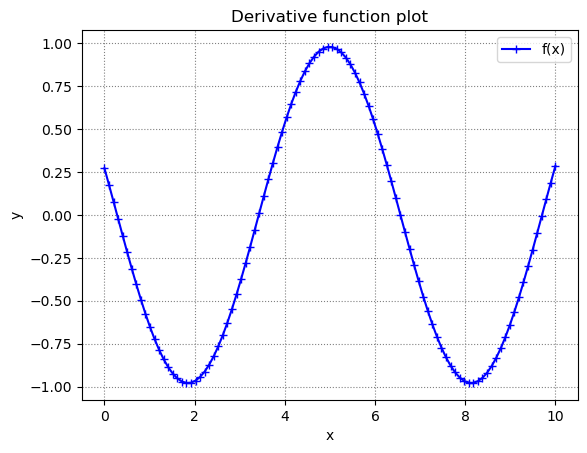

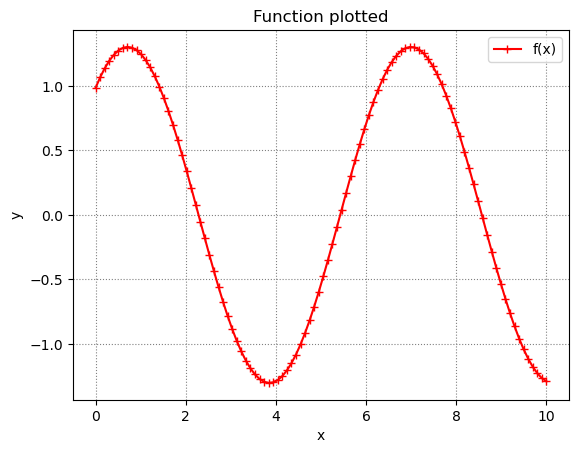

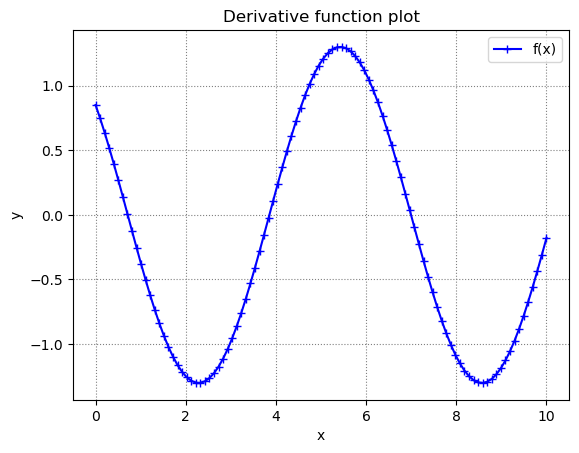

In [247]:
for k in range(2):
    Y = Y_values[k,:]
    Y_der = Y_der_values[k,:]
    plot_values(X_values, Y, color="red")
    plot_values(X_values, Y_der, color="blue", title="Derivative function plot")

### Training of the model

In [250]:
SON = SimpleOperatorNetwork(basis_functions, parametrized_function_numpy)

SON.load_state_dict(torch.load("pretrained_SON_2d.pth.tar", weights_only=True))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(SON.parameters(), lr=0.001)

SON.train()

num_epochs = 1000
training_loss = []
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    
    print("Currently in epoch ", epoch, "\t Progress: ", round(epoch/num_epochs*100, 2), "%", end="\r")
    
    loss = 0
    for i in range(N):
        Y_der_hat = SON(X_values, Y_values[i,:])
        Y_der = Y_der_values[i,:]
        
        loss += criterion(Y_der_hat.squeeze(), Y_der)
        
    training_loss.append(loss.item())
        
    loss.backward()

    optimizer.step()
    
    if epoch % 100 == 0:
        torch.save(SON.state_dict(), "pretrained_SON_2d.pth.tar")
    
torch.save(SON.state_dict(), "pretrained_SON_2d.pth.tar")

### Loading a pretrained model

In [254]:
SON = SimpleOperatorNetwork(basis_functions, parametrized_function_numpy)
SON.load_state_dict(torch.load("pretrained_SON_2d.pth.tar", weights_only=True))
SON.eval()

SimpleOperatorNetwork(
  (Encoder): Encoder()
  (LatentLinearLayer): LatentLinearLayer(
    (layer): Linear(in_features=2, out_features=2, bias=False)
  )
  (Decoder): Decoder()
)

In [256]:
print(SON.LatentLinearLayer.layer.weight)

Parameter containing:
tensor([[-0.0101, -1.0101],
        [-0.0092,  0.9908]], requires_grad=True)


### Model inference

We check the model output by testing with the trial function $f(x)=\sin(x)$. The model output should be "close" to the function $f'(x) = \cos(x)$

In [262]:
X_values = torch.linspace(0, 10, 100)

parameters = torch.tensor([1, 0, 0], dtype=torch.float32).unsqueeze(0)
der_parameters = torch.tensor([0, 1, 0], dtype=torch.float32).unsqueeze(0)

Dec = Decoder(basis_functions)
Y_values = Dec(X_values, parameters)
Y_der_values = Dec(X_values, der_parameters)

with torch.no_grad():
    Y_der_hat = SON(X_values, Y_values[0, :])

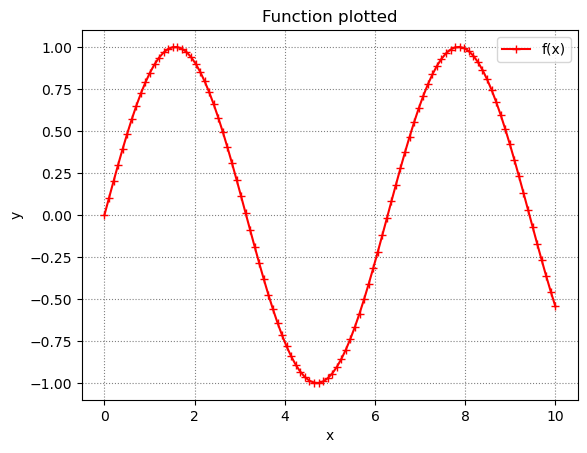

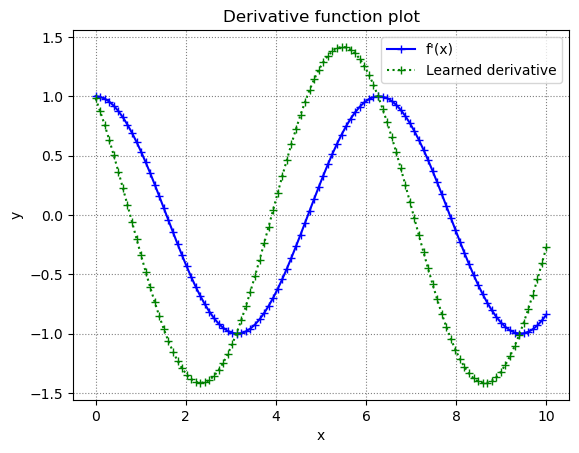

In [264]:
plot_values(X_values, Y_values.squeeze(), color="red")
plot_values(X_values, Y_der_values.squeeze(), color="blue", title="Derivative function plot", label="f'(x)",
            second_plot_y=Y_der_hat.squeeze())